In [71]:
%%capture
pip install import_ipynb

In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from harris import get_harris_corners, dist2
from skimage.transform import resize
import random

# Import functions from Part 4 notebook using import_ipynb
import import_ipynb
import sys
sys.path.append('/Users/prana/Documents/cs180/paida12.github.io/4/')

from mosaic import *

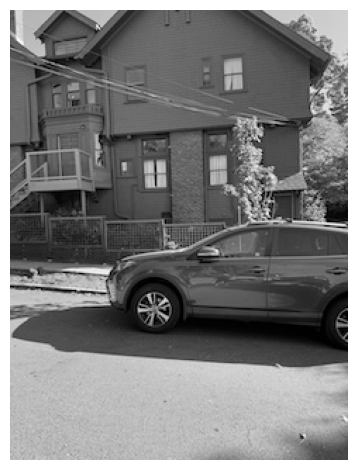

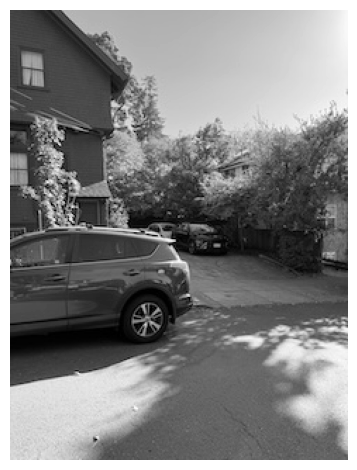

In [73]:
left_car = Image.open('../4/images/left_perspective.jpg').convert('L')
right_car = Image.open('../4/images/right_perspective.jpg').convert('L')

left_car = np.array(left_car)
right_car = np.array(right_car)

# Create final_images directory if it doesn't exist
import os
os.makedirs('./final_images', exist_ok=True)

plt.imshow(left_car, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig('./final_images/01_left_car_original.png', dpi=150, bbox_inches='tight')
plt.show()

plt.imshow(right_car, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig('./final_images/02_right_car_original.png', dpi=150, bbox_inches='tight')
plt.show()

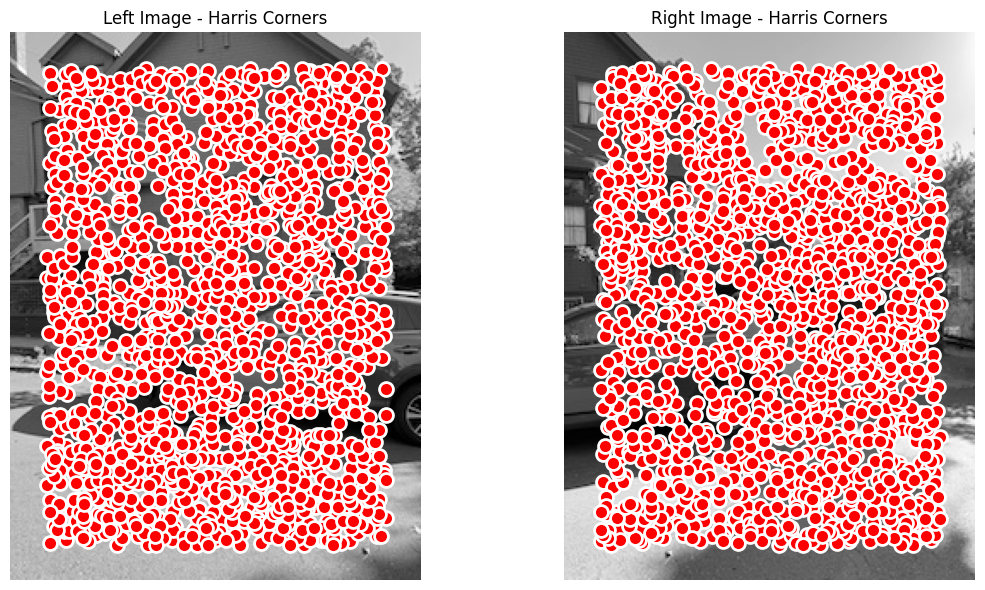

Number of Harris corners detected in left image: 1350
Number of Harris corners detected in right image: 1436


In [74]:
left_h, left_coords = get_harris_corners(left_car)
right_h, right_coords = get_harris_corners(right_car)

# Display left image with Harris corners
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(left_car, cmap='gray')
plt.scatter(left_coords[1], left_coords[0], c='red', s=100, marker='o', edgecolors='white', linewidth=2)
plt.title('Left Image - Harris Corners')
plt.axis('off')

# Display right image with Harris corners
plt.subplot(1, 2, 2)
plt.imshow(right_car, cmap='gray')
plt.scatter(right_coords[1], right_coords[0], c='red', s=100, marker='o', edgecolors='white', linewidth=2)
plt.title('Right Image - Harris Corners')
plt.axis('off')

plt.tight_layout()
plt.savefig('./final_images/03_harris_corners_all.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Number of Harris corners detected in left image: {left_coords.shape[1]}")
print(f"Number of Harris corners detected in right image: {right_coords.shape[1]}")


In [75]:
def anms(harris_map, corners, corner_count = 500):

    strengths = harris_map[corners[0], corners[1]]
    
    sorted_idx = np.argsort(-strengths)
    sorted_corners = corners[:, sorted_idx]

    sorted_strengths = strengths[sorted_idx]

    radius = np.full(len(sorted_strengths), np.inf)
    
    for i in range(1, len(sorted_strengths)):
        curr_corner = sorted_corners[:, i].reshape(1, 2)
        curr_strength = sorted_strengths[i]

        stronger_idx = np.where(sorted_strengths[: i] > 0.9 * curr_strength)[0]
        stronger_corners = sorted_corners[:, stronger_idx]

        if stronger_idx.size == 0:
            continue

        distances = dist2(stronger_corners.T, curr_corner)
        distances = np.sqrt(distances)

        radius[i] = np.min(distances)

    best_idx = np.argsort(-radius)[:corner_count]

    best_corners = sorted_corners[:, best_idx]
    best_radius = radius[best_idx]

    return best_corners, best_radius
    


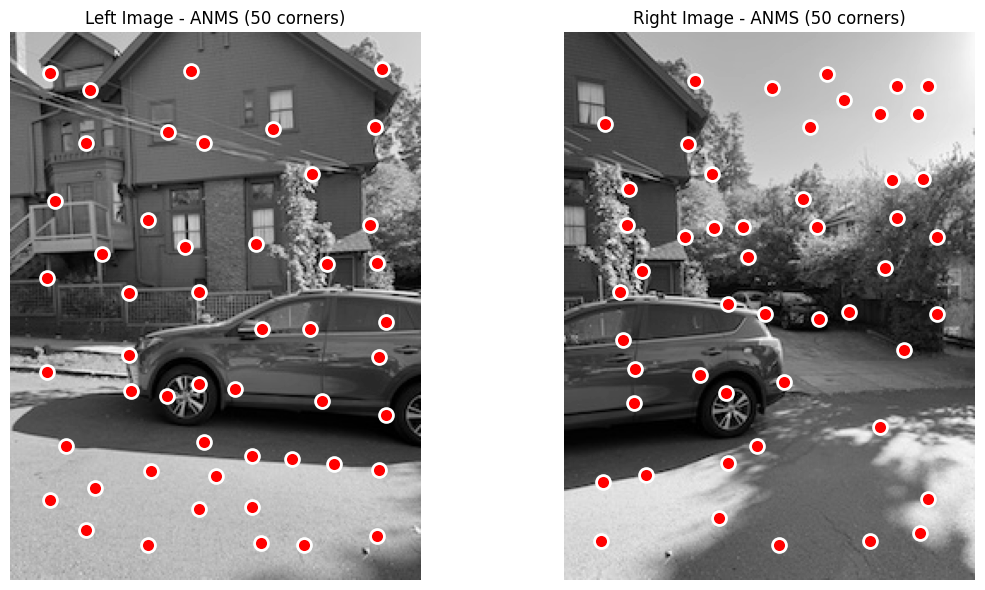

In [76]:
left_corners, left_radius = anms(left_h, left_coords, 50)
right_corners, right_radius = anms(right_h, right_coords, 50)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(left_car, cmap = 'gray')
plt.scatter(left_corners[1], left_corners[0], c = 'red', s = 100, marker = 'o', edgecolors = 'white', linewidth = 2)
plt.title('Left Image - ANMS (50 corners)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(right_car, cmap = 'gray')
plt.scatter(right_corners[1], right_corners[0], c = 'red', s = 100, marker = 'o', edgecolors = 'white', linewidth = 2)
plt.title('Right Image - ANMS (50 corners)')
plt.axis('off')
plt.tight_layout()
plt.savefig('./final_images/04_anms_corners.png', dpi=150, bbox_inches='tight')
plt.show()




In [77]:
def feature_extraction(image, corners):
    valid_corners = []
    features = []
    
    for i in range(len(corners[1])):
        y, x = corners[0][i], corners[1][i]

        patch = image[y - 20: y + 20, x - 20: x + 20]
        patch_8 = resize(patch, (8, 8), anti_aliasing = True)

        blurred_patch = patch_8 - np.mean(patch_8)
        std = np.std(blurred_patch)

        blurred_patch = blurred_patch / std

        feature = blurred_patch.flatten()

        features.append(feature)
        valid_corners.append((y, x))
    
    return np.array(features), np.array(valid_corners).T
    

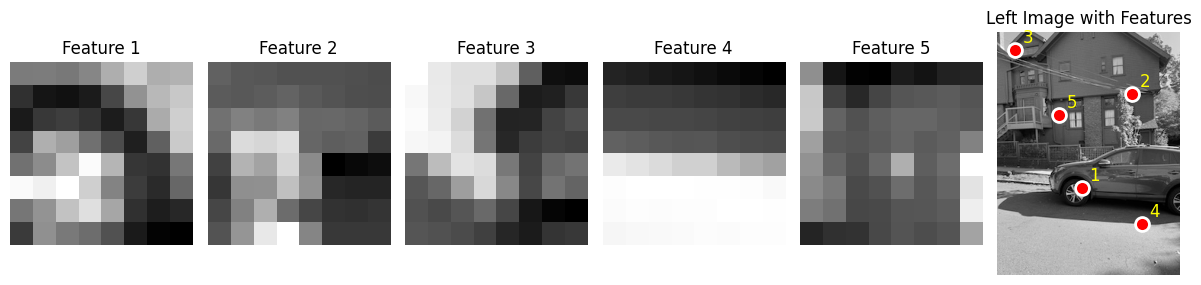

In [78]:
left_car_features, left_car_valid_corners = feature_extraction(left_car, left_corners)

plt.figure(figsize = (12, 6))

for i in range(5):
    plt.subplot(1, 6, i + 1)
    plt.imshow(left_car_features[i].reshape(8, 8), cmap = 'gray')
    plt.title(f'Feature {i + 1}')
    plt.axis('off')

plt.subplot(1, 6, 6)
plt.imshow(left_car, cmap = 'gray')
plt.scatter(left_car_valid_corners[1, :5], left_car_valid_corners[0, :5], c = 'red', s = 100, marker = 'o', edgecolors = 'white', linewidth = 2)

for i in range(5):
    y = left_car_valid_corners[0, i]
    x = left_car_valid_corners[1, i]
    plt.text(x + 10, y - 10, str(i + 1), color = 'yellow', fontsize = 12)
    
plt.title(f'Left Image with Features')
plt.axis('off')

plt.tight_layout()
plt.savefig('./final_images/05_left_car_8x8_features.png', dpi=150, bbox_inches='tight')
plt.show()

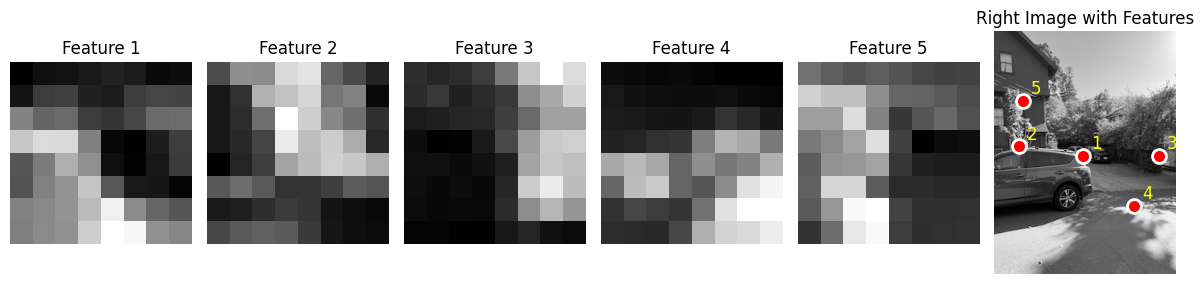

In [79]:
right_car_features, right_car_valid_corners = feature_extraction(right_car, right_corners)

plt.figure(figsize = (12, 6))

for i in range(5):
    plt.subplot(1, 6, i + 1)
    plt.imshow(right_car_features[i].reshape(8, 8), cmap = 'gray')
    plt.title(f'Feature {i + 1}')
    plt.axis('off')

plt.subplot(1, 6, 6)
plt.imshow(right_car, cmap = 'gray')
plt.scatter(right_car_valid_corners[1, :5], right_car_valid_corners[0, :5], c = 'red', s = 100, marker = 'o', edgecolors = 'white', linewidth = 2)

for i in range(5):
    y = right_car_valid_corners[0, i]
    x = right_car_valid_corners[1, i]
    plt.text(x + 10, y - 10, str(i + 1), color = 'yellow', fontsize = 12)

plt.title(f'Right Image with Features')
plt.axis('off')

plt.tight_layout()
plt.savefig('./final_images/06_right_car_8x8_features.png', dpi=150, bbox_inches='tight')
plt.show()

In [80]:
def feature_matching(left_corners, right_corners, left_img, right_img, threshold = 0.8):
    left_features, left_valid_corners = feature_extraction(left_img, left_corners)
    right_features, right_valid_corners = feature_extraction(right_img, right_corners)

    matches = []
    
    for i in range(left_features.shape[0]):
        left_feature = left_features[i].reshape(1, 64)

        distances = dist2(left_feature, right_features)[0]

        sorted_dist_idx = np.argsort(distances)
        smallest_dist_idx = sorted_dist_idx[0]
        second_smallest_dist_idx = sorted_dist_idx[1]

        ratio = distances[smallest_dist_idx] / distances[second_smallest_dist_idx]

        if ratio < threshold:
            matches.append((i, smallest_dist_idx)) # Index of left feature, index of right feature
            
    return np.array(matches), left_valid_corners, right_valid_corners

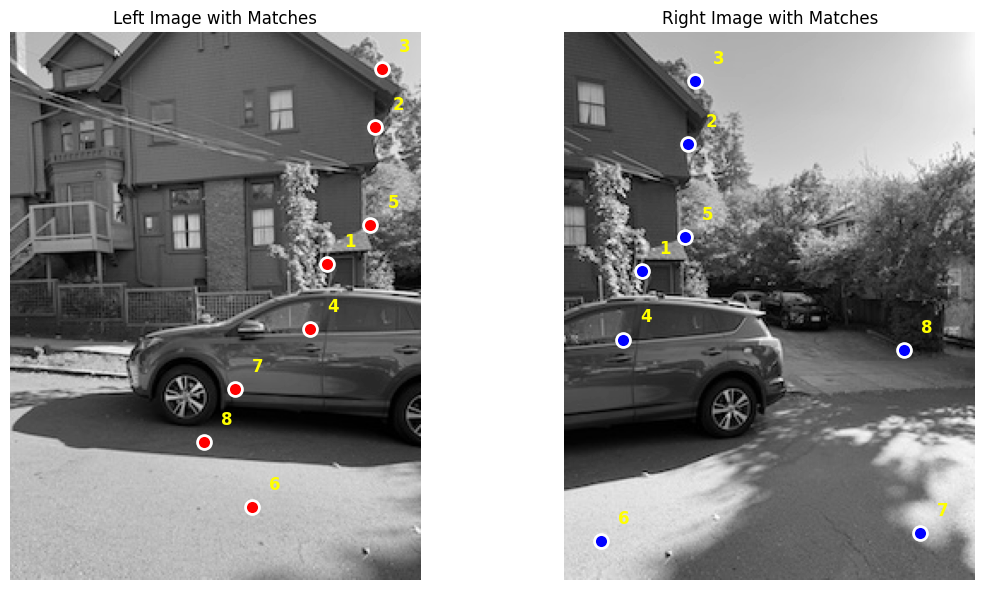

Threshold: 0.6
Number of matches found: 8


In [81]:
threshold = 0.60
matches, left_car_valid_corners, right_car_valid_corners = feature_matching(left_corners, right_corners, left_car, right_car, threshold)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(left_car, cmap='gray')
ax1.set_title('Left Image with Matches')
ax1.axis('off')

ax2.imshow(right_car, cmap='gray')
ax2.set_title('Right Image with Matches')
ax2.axis('off')

for count, (left_idx, right_idx) in enumerate(matches):
    # Left image
    ax1.scatter(
        left_car_valid_corners[1, left_idx],
        left_car_valid_corners[0, left_idx],
        c='red', s=100, marker='o', edgecolors='white', linewidth=2
    )
    ax1.text(
        left_car_valid_corners[1, left_idx] + 10,
        left_car_valid_corners[0, left_idx] - 10,
        str(count + 1),
        color='yellow', fontsize=12, fontweight='bold'
    )

    # Right image
    ax2.scatter(
        right_car_valid_corners[1, right_idx],
        right_car_valid_corners[0, right_idx],
        c='blue', s=100, marker='o', edgecolors='white', linewidth=2
    )
    ax2.text(
        right_car_valid_corners[1, right_idx] + 10,
        right_car_valid_corners[0, right_idx] - 10,
        str(count + 1),
        color='yellow', fontsize=12, fontweight='bold'
    )

plt.tight_layout()
plt.savefig('./final_images/07_feature_matches.png', dpi=150, bbox_inches='tight')
plt.show()

print("Threshold: " + str(threshold))
print(f"Number of matches found: {len(matches)}")



In [104]:
def ransac(left_img, right_img, threshold = 0.60, num_corners = 50, inlier_threshold = 5, match_count = 15):
    left_h, left_coords = get_harris_corners(left_img)
    right_h, right_coords = get_harris_corners(right_img)

    left_corners, left_radius = anms(left_h, left_coords, num_corners)
    right_corners, right_radius = anms(right_h, right_coords, num_corners)

    matches, left_valid_corners, right_valid_corners = feature_matching(left_corners, right_corners, left_img, right_img, threshold)

    best_inlier_count = 0
    best_H = None

    print(f"Starting RANSAC with {len(matches)} matches...")
    
    for i in range(10000):
        random_idx = np.random.choice(len(matches), 4, replace = False)

        random_matches = matches[random_idx]

        left_random_corners = left_valid_corners[:, random_matches[:, 0]]
        right_random_corners = right_valid_corners[:, random_matches[:, 1]]

        left_coords = list(zip(left_random_corners[1], left_random_corners[0]))
        right_coords = list(zip(right_random_corners[1], right_random_corners[0]))

        # Convert lists to numpy arrays for computeH
        left_coords = np.array(left_coords)
        right_coords = np.array(right_coords)
        
        H = computeH(right_coords, left_coords)

        # Finding Inliers

        inliers = []

        left_pts = left_valid_corners[:, matches[:, 0]]
        left_pts = np.column_stack((left_pts[1], left_pts[0]))

        right_pts = right_valid_corners[:, matches[:, 1]]
        right_pts = np.column_stack((right_pts[1], right_pts[0], np.ones(right_pts.shape[1])))


        warped_right_pts = H @ right_pts.T
        warped_right_pts = warped_right_pts[:2, :] / warped_right_pts[2, :]
        warped_right_pts = warped_right_pts.T

        dists = np.sqrt(np.sum((warped_right_pts - left_pts) ** 2, axis = 1))

        inliers = np.where(dists < inlier_threshold)[0]
        
        # Debug output every 100 iterations
        if i % 1000 == 0:
            print(f"Iteration {i}: {best_inlier_count} inliers (threshold: {inlier_threshold})")

        if len(inliers) > best_inlier_count:
            best_inlier_count = len(inliers)
            best_H = H
            print(f"New best homography found at iteration {i} with {len(inliers)} inliers")

    print(f"RANSAC completed. Best inlier count: {best_inlier_count}")
    
    if best_H is None:
        print("No valid homography found!")
        return None
    
    identity_matrix = np.eye(3)
    images_list = [left_img, right_img]
    homographies_list = [identity_matrix, best_H]

    mosaic_result = buildMosaic(images_list, homographies_list)

    return mosaic_result

Starting RANSAC with 140 matches...
Iteration 0: 0 inliers (threshold: 2)
New best homography found at iteration 0 with 5 inliers
New best homography found at iteration 1 with 11 inliers
New best homography found at iteration 2 with 23 inliers
New best homography found at iteration 4 with 69 inliers
New best homography found at iteration 15 with 70 inliers
New best homography found at iteration 70 with 92 inliers
New best homography found at iteration 129 with 94 inliers
Iteration 1000: 94 inliers (threshold: 2)
New best homography found at iteration 1099 with 100 inliers
Iteration 2000: 100 inliers (threshold: 2)
Iteration 3000: 100 inliers (threshold: 2)
Iteration 4000: 100 inliers (threshold: 2)
Iteration 5000: 100 inliers (threshold: 2)
Iteration 6000: 100 inliers (threshold: 2)
Iteration 7000: 100 inliers (threshold: 2)
New best homography found at iteration 7371 with 101 inliers
Iteration 8000: 101 inliers (threshold: 2)
Iteration 9000: 101 inliers (threshold: 2)
RANSAC completed

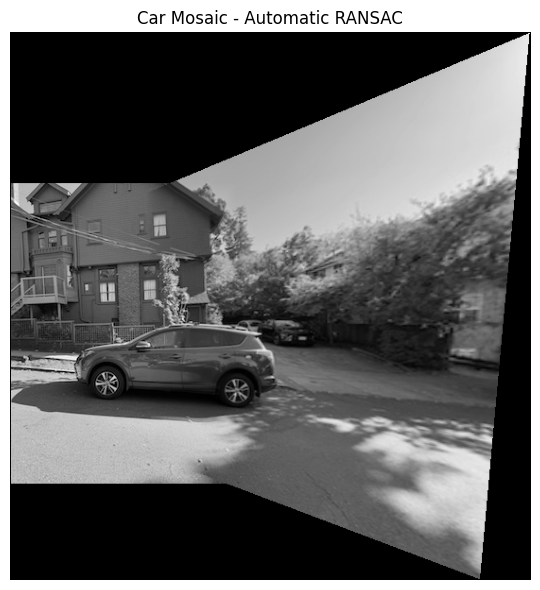

In [111]:
car_mosaic = ransac(left_car, right_car, threshold = 0.5, num_corners = 2000, inlier_threshold = 2, match_count = 25)
plt.figure(figsize=(12, 6))
plt.imshow(car_mosaic, cmap = 'gray')
plt.axis('off')
plt.title('Car Mosaic - Automatic RANSAC')
plt.tight_layout()
plt.savefig('./final_images/08_car_mosaic_ransac.png', dpi=150, bbox_inches='tight')
plt.show()

Starting RANSAC with 187 matches...
Iteration 0: 0 inliers (threshold: 2)
New best homography found at iteration 0 with 4 inliers
New best homography found at iteration 5 with 29 inliers
New best homography found at iteration 6 with 36 inliers
New best homography found at iteration 25 with 60 inliers
New best homography found at iteration 82 with 63 inliers
New best homography found at iteration 208 with 65 inliers
New best homography found at iteration 281 with 66 inliers
New best homography found at iteration 599 with 76 inliers
Iteration 1000: 76 inliers (threshold: 2)
New best homography found at iteration 1418 with 77 inliers
Iteration 2000: 77 inliers (threshold: 2)
Iteration 3000: 77 inliers (threshold: 2)
New best homography found at iteration 3559 with 81 inliers
Iteration 4000: 81 inliers (threshold: 2)
Iteration 5000: 81 inliers (threshold: 2)
Iteration 6000: 81 inliers (threshold: 2)
New best homography found at iteration 6497 with 84 inliers
Iteration 7000: 84 inliers (thr

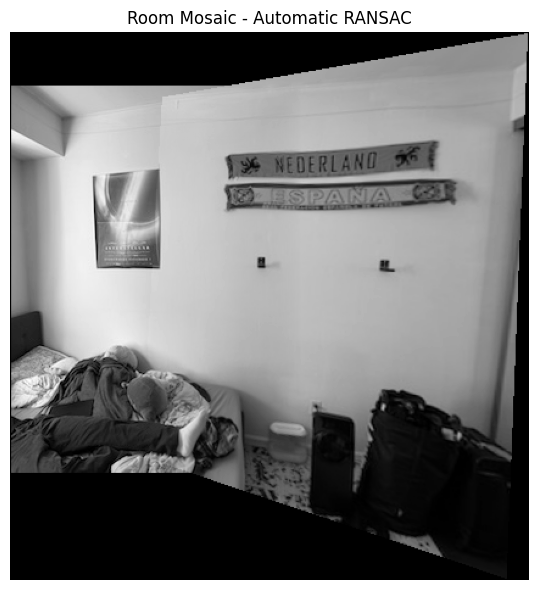

In [112]:
left_room = Image.open('./images/left_pic_room.jpg').convert('L')
right_room = Image.open('./images/right_pic_room.jpg').convert('L')

left_room = np.array(left_room)
right_room = np.array(right_room)

street_mosaic = ransac(left_room, right_room, threshold = 0.6, num_corners = 2000, inlier_threshold = 2, match_count = 25)

plt.figure(figsize=(12, 6))
plt.imshow(street_mosaic, cmap = 'gray')
plt.axis('off')
plt.title('Room Mosaic - Automatic RANSAC')
plt.tight_layout()
plt.savefig('./final_images/09_room_mosaic_ransac.png', dpi=150, bbox_inches='tight')
plt.show()

Starting RANSAC with 52 matches...
Iteration 0: 0 inliers (threshold: 5)
New best homography found at iteration 0 with 4 inliers
New best homography found at iteration 1 with 6 inliers
New best homography found at iteration 2 with 17 inliers
New best homography found at iteration 6 with 22 inliers
New best homography found at iteration 32 with 29 inliers
New best homography found at iteration 445 with 31 inliers
Iteration 1000: 31 inliers (threshold: 5)
New best homography found at iteration 1391 with 32 inliers
New best homography found at iteration 1418 with 33 inliers
Iteration 2000: 33 inliers (threshold: 5)
Iteration 3000: 33 inliers (threshold: 5)
Iteration 4000: 33 inliers (threshold: 5)
New best homography found at iteration 4332 with 34 inliers
Iteration 5000: 34 inliers (threshold: 5)
Iteration 6000: 34 inliers (threshold: 5)
Iteration 7000: 34 inliers (threshold: 5)
Iteration 8000: 34 inliers (threshold: 5)
Iteration 9000: 34 inliers (threshold: 5)
RANSAC completed. Best inl

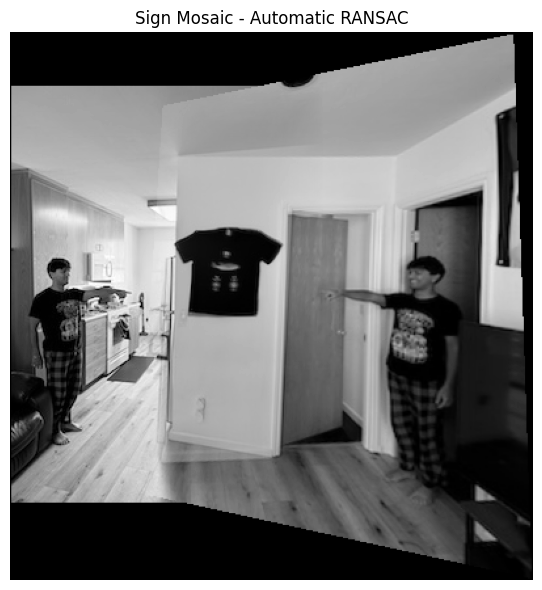

In [122]:
left_fih = Image.open('./images/left_image_fih.jpg').convert('L')
right_fih = Image.open('./images/right_image_fih.jpg').convert('L')

left_fih = np.array(left_fih)
right_fih = np.array(right_fih)

sign_mosaic = ransac(left_fih, right_fih, threshold = 0.45, num_corners = 1000, inlier_threshold = 5, match_count = 15)

plt.figure(figsize=(12, 6))
plt.imshow(sign_mosaic, cmap = 'gray')
plt.axis('off')
plt.title('Sign Mosaic - Automatic RANSAC')
plt.tight_layout()
plt.savefig('./final_images/10_sign_mosaic_ransac.png', dpi=150, bbox_inches='tight')
plt.show()

Starting RANSAC with 106 matches...
Iteration 0: 0 inliers (threshold: 2)
New best homography found at iteration 0 with 45 inliers
New best homography found at iteration 7 with 68 inliers
New best homography found at iteration 51 with 74 inliers
New best homography found at iteration 113 with 80 inliers
New best homography found at iteration 631 with 82 inliers
New best homography found at iteration 934 with 86 inliers
Iteration 1000: 86 inliers (threshold: 2)
Iteration 2000: 86 inliers (threshold: 2)
Iteration 3000: 86 inliers (threshold: 2)
Iteration 4000: 86 inliers (threshold: 2)
Iteration 5000: 86 inliers (threshold: 2)
Iteration 6000: 86 inliers (threshold: 2)
Iteration 7000: 86 inliers (threshold: 2)
Iteration 8000: 86 inliers (threshold: 2)
Iteration 9000: 86 inliers (threshold: 2)
RANSAC completed. Best inlier count: 86


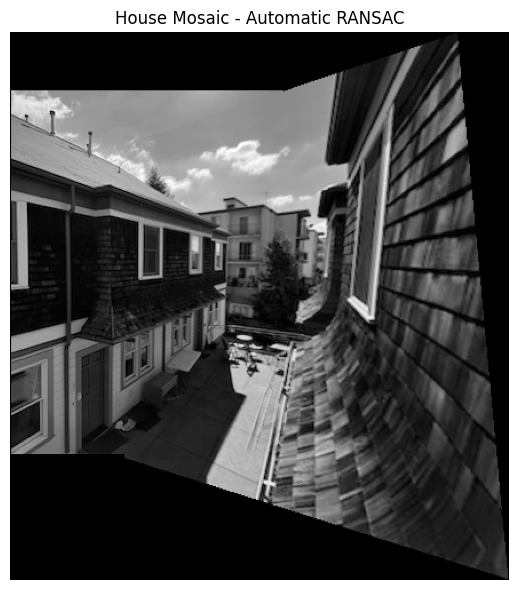

In [108]:
left_house = Image.open('./images/left_house.jpg').convert('L')
right_house = Image.open('./images/right_house.jpg').convert('L')

left_house = np.array(left_house)
right_house = np.array(right_house)

house_mosaic = ransac(left_house, right_house, threshold = 0.45, num_corners = 500, inlier_threshold = 2, match_count = 15)

plt.figure(figsize=(12, 6))
plt.imshow(house_mosaic, cmap = 'gray')
plt.axis('off')
plt.title('House Mosaic - Automatic RANSAC')
plt.tight_layout()
plt.savefig('./final_images/11_house_mosaic_ransac.png', dpi=150, bbox_inches='tight')
plt.show()